<h1 style='color:blue; background-color:rgb(220,220,220)'><center>Symbolic Music Production using Generative Adversarial Networks (GANs)</center></h1>

---

<b style='color:DodgerBlue'><center>Mughees Asif – 180288337</center></b>
<i style='color:rgb(0, 122, 172)'><center>ECS7022P - Computational Creativity</center></i>
<i style='color:rgb(0, 122, 172)'><center>School of Electronic Engineering and Computer Science</center></i>
<i style='color:rgb(0, 122, 172)'><center> Queen Mary, University of London</center></i>

<img src="./images/chopin_intro.jpg" alt="chopin" style="width: 500px;"/>

## Abstract

The following notebook ....

## Contents

---

**1** &nbsp;&nbsp;**[Download dependencies](#dw-dep)**<br>
**2** &nbsp;&nbsp;**[Imports](#imports)**<br>
**3** &nbsp;&nbsp;**[Save output](#save-output)**<br>
**4** &nbsp;&nbsp;**[Preprocess data](#preprocess-data)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.1&nbsp;&nbsp;*[Sample the data](#sample-data)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.2&nbsp;&nbsp;*[Data representation](#data-representation)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.3&nbsp;&nbsp;*[Load the data](#loaddata)*<br>
**5** &nbsp;&nbsp;**[Generative Adversarial Network](#gan)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1&nbsp;&nbsp;*[Generator](#generator)*<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2&nbsp;&nbsp;*[Discriminator](#discriminator)*<br>

## 1&nbsp;&nbsp;Download dependencies <a class="anchor" id="dw-dep"></a>

In [1]:
print('Downloading dependencies...')

!pip install -q numpy
!pip install -q scipy
!pip install -q matplotlib
!pip install -q ipython
!pip install -q pypianoroll
print('Almost done...')
!pip install -q tensorflow==1.15.0

print('Dependencies downloaded and ready!')

Almost done...
Dependencies downloaded and ready!


ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0)
ERROR: No matching distribution found for tensorflow==1.15.0


## 2&nbsp;&nbsp;Imports <a class="anchor" id="imports"></a>

In [2]:
print('Importing necessary dependencies...')

import os 
import numpy as np
from PIL import Image
import pypianoroll
import scipy.stats
import pickle
import music21
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf

# Utils library for plotting, loading and saving midi among other functions
from utils import display_utils, metrics_utils, path_utils, inference_utils, midi_utils

%matplotlib inline

print('Ready!')

Importing necessary dependencies...
Ready!


## 3&nbsp;&nbsp;Save output <a class="anchor" id="save-output"></a>

In [3]:
print('Setuping the folder structure to save the output...')

root_dir = './output'

# Directory to save checkpoints
model_dir = os.path.join(root_dir,'checkpoints')    # JSP: 229, Bach: 19199

# Directory to save pianorolls during training
train_dir = os.path.join(model_dir, 'train')

# Directory to save checkpoint generated during training
check_dir = os.path.join(model_dir, 'load_saved')

# Directory to save midi during training
sample_dir = os.path.join(model_dir, 'saved_samples')

# Directory to save samples generated during inference
eval_dir = os.path.join(model_dir, 'evaluation_samples')

make_dir = [train_dir, eval_dir, sample_dir]
for i in range(len(make_dir)):
  os.makedirs(make_dir[i], exist_ok=True)

print('Done!')

Setuping the folder structure to save the output...
Done!


## 4&nbsp;&nbsp;Preprocess data <a class="anchor" id="preprocess-data"></a>

### 4.1 *Sample the data* <a class="anchor" id="sample-data"></a>

In [4]:
display_utils.playmidi('./original_midi/MIDI-0.mid')

### 4.2 *Data representation* <a class="anchor" id="data-representation"></a>

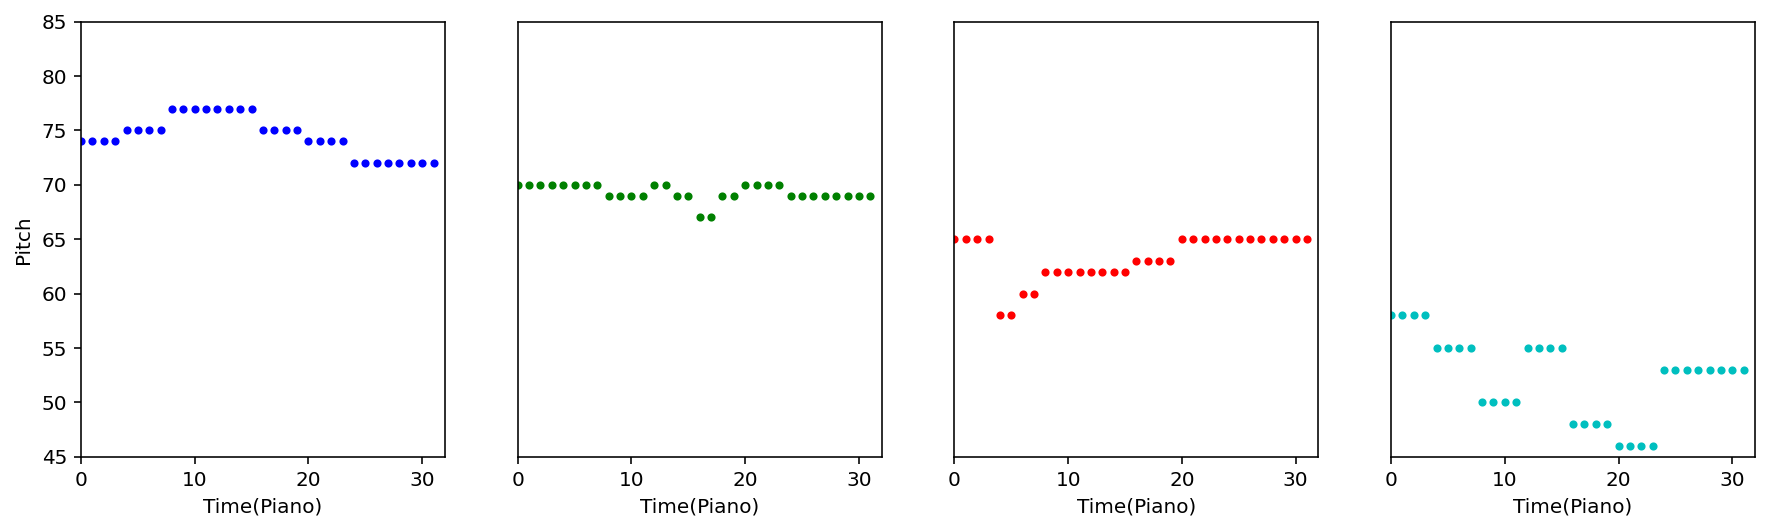

In [5]:
training_data = np.load('./dataset/train.npy')
display_utils.show_pianoroll(training_data)

### 4.2 *Load the data* <a class="anchor" id="load-data"></a>

In [6]:
#Number of input data samples in a batch
BATCH_SIZE = 64

#Shuffle buffer size for shuffling data
SHUFFLE_BUFFER_SIZE = 1000

#Preloads PREFETCH_SIZE batches so that there is no idle time between batches
PREFETCH_SIZE = 4

def prepare_dataset(filename):
    
    """Load the samples used for training."""
    
    data = np.load(filename)
    data = np.asarray(data, dtype=np.float32)  # {-1, 1}
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat()
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(PREFETCH_SIZE)

    return dataset 

dataset = prepare_dataset('./dataset/train.npy')

## 5&nbsp;&nbsp;Generative Adversarial Network <a class="anchor" id="gan"></a>

### 5.1 *Generator* <a class="anchor" id="generator"></a>

In [7]:
def _conv2d(layer_input, filters, f_size=4, bn=True):
    """Generator Basic Downsampling Block"""
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,
                               padding='same')(layer_input)
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    if bn:
        d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
    return d


def _deconv2d(layer_input, pre_input, filters, f_size=4, dropout_rate=0):
    """Generator Basic Upsampling Block"""
    u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
    u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=1,
                               padding='same')(u)
    u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
    u = tf.keras.layers.ReLU()(u)

    if dropout_rate:
        u = tf.keras.layers.Dropout(dropout_rate)(u)
        
    u = tf.keras.layers.Concatenate()([u, pre_input])
    return u

    
def build_generator(condition_input_shape=(32, 128, 1), filters=64,
                    instruments=4, latent_shape=(2, 8, 512)):
    """Buld Generator"""
    c_input = tf.keras.layers.Input(shape=condition_input_shape)
    z_input = tf.keras.layers.Input(shape=latent_shape)

    d1 = _conv2d(c_input, filters, bn=False)
    d2 = _conv2d(d1, filters * 2)
    d3 = _conv2d(d2, filters * 4)
    d4 = _conv2d(d3, filters * 8)

    d4 = tf.keras.layers.Concatenate(axis=-1)([d4, z_input])

    u4 = _deconv2d(d4, d3, filters * 4)
    u5 = _deconv2d(u4, d2, filters * 2)
    u6 = _deconv2d(u5, d1, filters)

    u7 = tf.keras.layers.UpSampling2D(size=2)(u6)
    output = tf.keras.layers.Conv2D(instruments, kernel_size=4, strides=1,
                               padding='same', activation='tanh')(u7)  # 32, 128, 4

    generator = tf.keras.models.Model([c_input, z_input], output, name='Generator')

    return generator

# Models
generator = build_generator()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 16, 64, 64)   1088        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 32, 128)   131200      ['leaky_re_lu[0][0]']    

### 5.2 *Discriminator* <a class="anchor" id="discriminator"></a>

In [8]:
def _build_critic_layer(layer_input, filters, f_size=4):
    """
    This layer decreases the spatial resolution by 2:

        input:  [batch_size, in_channels, H, W]
        output: [batch_size, out_channels, H/2, W/2]
    """
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2,
                               padding='same')(layer_input)
    # Critic does not use batch-norm
    d = tf.keras.layers.LeakyReLU(alpha=0.2)(d) 
    return d


def build_critic(pianoroll_shape=(32, 128, 4), filters=64):
    """WGAN critic."""
    
    condition_input_shape = (32,128,1)
    groundtruth_pianoroll = tf.keras.layers.Input(shape=pianoroll_shape)
    condition_input = tf.keras.layers.Input(shape=condition_input_shape)
    combined_imgs = tf.keras.layers.Concatenate(axis=-1)([groundtruth_pianoroll, condition_input])


    
    d1 = _build_critic_layer(combined_imgs, filters)
    d2 = _build_critic_layer(d1, filters * 2)
    d3 = _build_critic_layer(d2, filters * 4)
    d4 = _build_critic_layer(d3, filters * 8)

    x = tf.keras.layers.Flatten()(d4)
    logit = tf.keras.layers.Dense(1)(x)

    critic = tf.keras.models.Model([groundtruth_pianoroll,condition_input], logit,
                                          name='Critic')
    

    return critic

# Create the Discriminator

critic = build_critic()
critic.summary() # View discriminator architecture.

Model: "Critic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 128, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 32, 128, 5)   0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']           

## 6&nbsp;&nbsp;Training <a class="anchor" id="training"></a>

In [9]:
# Define the different loss functions

def generator_loss(critic_fake_output):
    """ Wasserstein GAN loss
    (Generator)  -D(G(z|c))
    """
    return -tf.reduce_mean(critic_fake_output)


def wasserstein_loss(critic_real_output, critic_fake_output):
    """ Wasserstein GAN loss
    (Critic)  D(G(z|c)) - D(x|c)
    """
    return tf.reduce_mean(critic_fake_output) - tf.reduce_mean(
        critic_real_output)


def compute_gradient_penalty(critic, x, fake_x):
    
    c = tf.expand_dims(x[..., 0], -1)
    batch_size = x.get_shape().as_list()[0]
    eps_x = tf.random.uniform(
        [batch_size] + [1] * (len(x.get_shape()) - 1))  # B, 1, 1, 1, 1
    inter = eps_x * x + (1.0 - eps_x) * fake_x

    with tf.GradientTape() as g:
        g.watch(inter)
        disc_inter_output = critic((inter,c), training=True)
    grads = g.gradient(disc_inter_output, inter)
    slopes = tf.sqrt(1e-8 + tf.reduce_sum(
        tf.square(grads)))
    gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))
    
    return gradient_penalty


In [10]:
# Setup Adam optimizers for both G and D
generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
critic_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)

# We define our checkpoint directory and where to save trained checkpoints
ckpt = tf.train.Checkpoint(generator=generator,
                           generator_optimizer=generator_optimizer,
                           critic=critic,
                           critic_optimizer=critic_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, check_dir, max_to_keep=5)

In [11]:
@tf.function
def generator_train_step(x, condition_track_idx=0):

    ############################################
    #(1) Update G network: maximize D(G(z|c))
    ############################################

    # Extract condition track to make real batches pianoroll
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Generate batch of latent vectors
    z = tf.random.truncated_normal([BATCH_SIZE, 2, 8, 512])

    with tf.GradientTape() as tape:
        fake_x = generator((c, z), training=True)
        fake_output = critic((fake_x,c), training=False)

        # Calculate Generator's loss based on this generated output
        gen_loss = generator_loss(fake_output)

    # Calculate gradients for Generator
    gradients_of_generator = tape.gradient(gen_loss,
                                           generator.trainable_variables)
    # Update Generator
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss


In [12]:
@tf.function
def critic_train_step(x, condition_track_idx=0):

    ############################################################################
    #(2) Update D network: maximize (D(x|c)) + (1 - D(G(z|c))|c) + GradientPenality() 
    ############################################################################

    # Extract condition track to make real batches pianoroll
    c = tf.expand_dims(x[..., condition_track_idx], -1)

    # Generate batch of latent vectors
    z = tf.random.truncated_normal([BATCH_SIZE, 2, 8, 512])

    # Generated fake pianoroll
    fake_x = generator((c, z), training=False)


    # Update critic parameters
    with tf.GradientTape() as tape:
        real_output = critic((x,c), training=True)
        fake_output = critic((fake_x,c), training=True)
        critic_loss =  wasserstein_loss(real_output, fake_output)

    # Caculate the gradients from the real and fake batches
    grads_of_critic = tape.gradient(critic_loss,
                                               critic.trainable_variables)

    with tf.GradientTape() as tape:
        gp_loss = compute_gradient_penalty(critic, x, fake_x)
        gp_loss *= 10.0

    # Calculate the gradients penalty from the real and fake batches
    grads_gp = tape.gradient(gp_loss, critic.trainable_variables)
    gradients_of_critic = [g + ggp for g, ggp in
                                  zip(grads_of_critic, grads_gp)
                                  if ggp is not None]

    # Update Critic
    critic_optimizer.apply_gradients(
        zip(gradients_of_critic, critic.trainable_variables))

    return critic_loss + gp_loss


In [13]:
# We use load_melody_samples() to load 10 input data samples from our dataset into sample_x 
# and 10 random noise latent vectors into sample_z
sample_x, sample_z = inference_utils.load_melody_samples(n_sample=10)

Loaded 10 melody samples


In [14]:
# Number of iterations to train for
iterations = 1000

# Update critic n times per generator update 
n_dis_updates_per_gen_update = 5

# Determine input track in sample_x that we condition on
condition_track_idx = 0 
sample_c = tf.expand_dims(sample_x[..., condition_track_idx], -1)

In [15]:
tf.config.run_functions_eagerly(True)

In [34]:
# Clear out any old metrics we've collected
metrics_utils.metrics_manager.initialize()

@tf.function
def run_training():
    # Keep a running list of various quantities:
    c_losses = []
    g_losses = []
    
    # Data iterator to iterate over our dataset
    it = iter(dataset)
    
    for iteration in range(iterations):
        # Train critic
        for _ in range(n_dis_updates_per_gen_update):
            c_loss = critic_train_step(next(it))

            # Train generator
            g_loss = generator_train_step(next(it))

            # Save Losses for plotting later
            c_losses.append(c_loss)
            g_losses.append(g_loss)

            #       fig = plt.figure(figsize=(15, 5))
            #       display.display(fig)
            #       display.clear_output(wait=True)
            #       line1, = plt.plot(range(iteration+1), c_losses, 'r')
            #       line2, = plt.plot(range(iteration+1), g_losses, 'k')
            #       plt.xlabel('Iterations')
            #       plt.ylabel('Losses')
            #       plt.legend((line1, line2), ('C-loss', 'G-loss'))
            #       plt.close(fig)

            # Output training stats
            print('Iteration {}, c_loss={:.2f}, g_loss={:.2f}'.format(iteration, c_loss, g_loss))
      
            # Save checkpoints, music metrics, generated output
            if iteration < 100 or iteration % 50 == 0 :
                # Check how the generator is doing by saving G's samples on fixed_noise
                fake_sample_x = generator((sample_c, sample_z), training=False)
                metrics_utils.metrics_manager.append_metrics_for_iteration(fake_sample_x.numpy(), iteration)

                if iteration % 50 == 0:
                  # Save the checkpoint to disk.
                  ckpt_manager.save(checkpoint_number=iteration) 

                fake_sample_x = fake_sample_x.numpy()

                # plot the pianoroll
                display_utils.plot_pianoroll(iteration, sample_x[:4], fake_sample_x[:4], save_dir=train_dir)

                # generate the midi
#                 destination_path = path_utils.generated_midi_path_for_iteration(iteration, saveto_dir=sample_dir)
#                 midi_utils.save_pianoroll_as_midi(fake_sample_x[:4], destination_path=destination_path)


In [35]:
run_training()

Iteration 0, c_loss=-1.08, g_loss=-2.26
Iteration 0, c_loss=0.11, g_loss=-0.69
Iteration 0, c_loss=-0.63, g_loss=-1.43
Iteration 0, c_loss=-0.73, g_loss=-2.87
Iteration 0, c_loss=-0.91, g_loss=-4.27
Iteration 1, c_loss=-0.72, g_loss=-2.88
Iteration 1, c_loss=-0.57, g_loss=-4.05
Iteration 1, c_loss=-0.28, g_loss=-3.05
Iteration 1, c_loss=-0.39, g_loss=-4.50
Iteration 1, c_loss=-0.27, g_loss=-3.40
Iteration 2, c_loss=-0.37, g_loss=-4.02
Iteration 2, c_loss=-0.20, g_loss=-3.24
Iteration 2, c_loss=-0.38, g_loss=-3.26
Iteration 2, c_loss=0.78, g_loss=-2.50
Iteration 2, c_loss=0.76, g_loss=-3.42
Iteration 3, c_loss=1.98, g_loss=-2.19
Iteration 3, c_loss=0.43, g_loss=-1.98
Iteration 3, c_loss=1.18, g_loss=-1.82
Iteration 3, c_loss=0.54, g_loss=-2.41
Iteration 3, c_loss=-0.25, g_loss=-3.00
Iteration 4, c_loss=0.50, g_loss=-2.15
Iteration 4, c_loss=0.07, g_loss=-1.36
Iteration 4, c_loss=0.01, g_loss=-1.71
Iteration 4, c_loss=-0.02, g_loss=-2.00
Iteration 4, c_loss=-0.07, g_loss=-0.34
Iteration 

KeyboardInterrupt: 